In [22]:
import os
import sys
import glob
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm
sys.path.append("../../Utils")
from loaders import HNSCCFeatureHandler

METADATA_PATH = "../../Supplementary_Tables/ST1/RAW_HNSCC_METADATA_NEW_v11.csv"
VALID_IDS_PATH = "../../Utils/Lists/cv_ids.txt"
HOLD_IDS_PATH = '../../Utils/Lists/holdout_ids.txt'

hc_data = HNSCCFeatureHandler(METADATA_PATH, VALID_IDS_PATH, HOLD_IDS_PATH)
_ = hc_data.load_feature_to_dataframe("../../Data/*.hg38.frag.interval_mds.tsv", 0, 4)
z = hc_data.normalize_zscore()
_ = hc_data.merge_feature_metadata()
z = hc_data.batch_correct()

with open('tumor_fraction_from_median.pkl', 'rb') as f:
    tumor = pickle.load(f)

In [23]:
s = hc_data.get_metadata_col('Patient Number', df=pd.concat([hc_data.data, hc_data.hold_data], axis=0))
switched_df = s.reset_index().drop_duplicates(subset='Patient Number', keep='first')
switched = switched_df.set_index('Patient Number')['index']

In [24]:
tumor = {switched.get(k, k): v for k, v in tumor.items()}

In [25]:
full_df = pd.concat([hc_data.data, hc_data.hold_data], axis=0)

old_relapse_adj = hc_data.get_metadata_col('OLD Relapse Months (Adjuvant)', df=full_df)
relapse_adj = hc_data.get_metadata_col('Relapse Months (Adjuvant)', df=full_df)

old_surv_adj = hc_data.get_metadata_col('OLD Survival Months (Adjuvant)', df=full_df)
surv_adj = hc_data.get_metadata_col('Survival Months (Adjuvant)', df=full_df)

old_relapse_surg = hc_data.get_metadata_col('OLD Relapse Months (Surgery)', df=full_df)
relapse_surg = hc_data.get_metadata_col('Relapse Months (Surgery)', df=full_df)

old_surv_surg = hc_data.get_metadata_col('OLD Survival Months (Surgery)', df=full_df)
surv_surg = hc_data.get_metadata_col('Survival Months (Surgery)', df=full_df)

old_relapse_neoadj = hc_data.get_metadata_col('OLD Relapse Months (Neoadjuvant)', df=full_df)
relapse_neoadj = hc_data.get_metadata_col('Relapse Months (Neoadjuvant)', df=full_df)

old_surv_neoadj = hc_data.get_metadata_col('OLD Survival Months (Neoadjuvant)', df=full_df)
surv_neoadj = hc_data.get_metadata_col('Survival Months (Neoadjuvant)', df=full_df)

old_relapse_status = hc_data.get_metadata_col('OLD E_Relapse', df=full_df).astype(bool)
relapse_status = hc_data.get_metadata_col('E_Relapse', df=full_df).astype(bool)

old_surv_status = hc_data.get_metadata_col('OLD E_Survival', df=full_df).astype(bool)
surv_status = hc_data.get_metadata_col('E_Survival', df=full_df).astype(bool)

stratification = hc_data.get_metadata_col('Stratification', df=full_df)
truth_response = hc_data.get_metadata_col('Treatment Response', df=full_df)

patient_number = hc_data.get_metadata_col('Patient Number', df=full_df)
diagnosis = hc_data.get_metadata_col('Diagnosis', df=full_df)
age = hc_data.get_metadata_col('Age', df=full_df)
gender = hc_data.get_metadata_col('Gender', df=full_df)
smoking = hc_data.get_metadata_col('Smoking', df=full_df)
alcohol = hc_data.get_metadata_col('Alcohol', df=full_df)
race = hc_data.get_metadata_col('Race', df=full_df)
ethnicity = hc_data.get_metadata_col('Ethnicity', df=full_df)
hpv = hc_data.get_metadata_col('HPV', df=full_df)
pdl1_ihc = hc_data.get_metadata_col('PDL1 IHC', df=full_df).replace({0: "0", 1: "1-19", 2: ">20"})

keep_idx = list(tumor.keys())
cols_to_filter = [
    old_relapse_adj, relapse_adj,
    old_surv_adj, surv_adj,
    old_relapse_status, relapse_status,
    old_surv_status, surv_status,
    stratification, truth_response,
    patient_number, diagnosis, age, gender,
    smoking, alcohol, race, ethnicity, hpv, pdl1_ihc
]

filtered_cols = [col[col.index.isin(keep_idx)] for col in cols_to_filter]
(
    old_relapse_adj, relapse_adj,
    old_surv_adj, surv_adj,
    old_relapse_status, relapse_status,
    old_surv_status, surv_status,
    stratification, truth_response,
    patient_number, diagnosis, age, gender,
    smoking, alcohol, race, ethnicity, hpv, pdl1_ihc
) = filtered_cols

merged_df = pd.concat([
    old_surv_adj, surv_adj,
    old_relapse_adj, relapse_adj,
    old_surv_surg, surv_surg,
    old_relapse_surg, relapse_surg,
    old_surv_neoadj, surv_neoadj,
    old_relapse_neoadj, relapse_neoadj,
    old_surv_status, surv_status,
    old_relapse_status, relapse_status,
    stratification, truth_response,
    patient_number, diagnosis, age, gender,
    smoking, alcohol, race, ethnicity, hpv, pdl1_ihc
], axis=1)

merged_df.columns = [
    'OLD Survival Months (Adjuvant)', 'Survival Months (Adjuvant)',
    'OLD Relapse Months (Adjuvant)', 'Relapse Months (Adjuvant)',
    'OLD Survival Months (Surgery)', 'Survival Months (Surgery)',
    'OLD Relapse Months (Surgery)', 'Relapse Months (Surgery)',
    'OLD Survival Months (Neoadjuvant)', 'Survival Months (Neoadjuvant)',
    'OLD Relapse Months (Neoadjuvant)', 'Relapse Months (Neoadjuvant)',
    'OLD E_Survival', 'E_Survival',
    'OLD E_Relapse', 'E_Relapse',
    'Stratification', 'Treatment Response',
    'Patient Number', 'Diagnosis', 'Age', 'Gender',
    'Smoking', 'Alcohol', 'Race', 'Ethnicity', 'HPV', 'PDL1 IHC'
]

if 'tumor' in globals():
    merged_df['Tumor Fraction'] = merged_df.index.map(tumor)


In [26]:
merged_df = merged_df[merged_df['Treatment Response'].notna()]

In [27]:
def get_mean_y_score_by_patient(csv_path, name):
    df = pd.read_csv(csv_path)
    patient_scores = {}

    for _, row in df.iterrows():
        if row['fold'].startswith(name):
            y_score = [float(x) for x in row['probabilities'].strip("[]").replace('\n', ' ').split(',') if x]
            patient_list = [int(float(x)) for x in row['patients'].strip("[]").replace('\n', ' ').split(',') if x]
    
            for patient, score in zip(patient_list, y_score):
                patient_scores.setdefault(patient, []).append(score)

    mean_scores = {patient: np.mean(scores) for patient, scores in patient_scores.items()}
    return mean_scores

In [28]:
repinst_probabilities = get_mean_y_score_by_patient("SURV_PREDICTIONS.csv", "MDS_Institute")
merged_df['REPINST_Probabilities'] = merged_df['Patient Number'].map(repinst_probabilities)

merged_df['REPINST_Predictions'] = merged_df['REPINST_Probabilities'].apply(
    lambda x: 'Responder' if x > 0.5 else 'Non-Responder'
)

rephold_probabilities = get_mean_y_score_by_patient("SURV_PREDICTIONS.csv", "MDS_Pre_Hold_Out")
merged_df['REPHOLD_Probabilities'] = merged_df['Patient Number'].map(rephold_probabilities)

merged_df['REPHOLD_Predictions'] = merged_df['REPHOLD_Probabilities'].apply(
    lambda x: 'Responder' if x > 0.5 else 'Non-Responder'
)

In [29]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
merged_df

,OLD Survival Months (Adjuvant),Survival Months (Adjuvant),OLD Relapse Months (Adjuvant),Relapse Months (Adjuvant),OLD Survival Months (Surgery),Survival Months (Surgery),OLD Relapse Months (Surgery),Relapse Months (Surgery),OLD Survival Months (Neoadjuvant),Survival Months (Neoadjuvant),OLD Relapse Months (Neoadjuvant),Relapse Months (Neoadjuvant),OLD E_Survival,E_Survival,OLD E_Relapse,E_Relapse,Stratification,Treatment Response,Patient Number,Diagnosis,Age,Gender,Smoking,Alcohol,Race,Ethnicity,HPV,PDL1 IHC,Tumor Fraction,REPINST_Probabilities,REPINST_Predictions,REPHOLD_Probabilities,REPHOLD_Predictions
Pilot2_3,18.033333,18.033333,10.400000,10.400000,19.290323,19.290323,11.645161,11.645161,19.516129,19.516129,11.870968,11.870968,True,True,True,True,High,Non-Responder,1.0,Oral Cavity,44.0,Female,Yes,No,White,Non-Hispanic,Unknown,1-19,Low Tumor Fraction,0.409145,Non-Responder,0.678774,Responder
Pilot2_6,3.225806,3.225806,1.451613,1.451613,4.866667,4.866667,3.066667,3.066667,5.433333,5.433333,3.666667,3.666667,True,True,True,True,High,Responder,2.0,Oral Cavity,51.0,Male,No,No,White,Non-Hispanic,Unknown,1-19,Low Tumor Fraction,0.403700,Non-Responder,0.435313,Non-Responder
Pilot2_9,10.129032,54.000000,10.129032,54.000000,11.200000,55.066667,11.200000,55.066667,11.433333,55.300000,11.433333,55.300000,False,False,False,False,High,Responder,3.0,Oral Cavity,71.0,Female,Yes,No,White,Non-Hispanic,Unknown,1-19,High Tumor Fraction,0.435823,Non-Responder,0.635519,Responder
Pilot2_12,NaN,NaN,NaN,NaN,10.700000,34.733333,10.700000,34.733333,10.966667,35.000000,10.966667,35.000000,False,False,False,False,Intermediate,Responder,4.0,Larynx,75.0,Male,Yes,No,White,Non-Hispanic,Unknown,1-19,Low Tumor Fraction,0.414676,Non-Responder,0.340104,Non-Responder
Pilot2_14,22.064516,22.064516,8.709677,8.709677,23.161290,23.161290,9.806452,9.806452,23.633333,23.633333,10.266667,10.266667,True,True,True,True,High,Non-Responder,5.0,Oral Cavity,70.0,Female,No,No,White,Non-Hispanic,Unknown,1-19,Low Tumor Fraction,0.304299,Non-Responder,0.578612,Responder
Pilot2_16,29.366667,29.366667,10.733333,10.733333,30.709677,30.709677,12.096774,12.096774,31.096774,31.096774,12.451613,12.451613,False,False,True,True,Intermediate,Non-Responder,6.0,Oral Cavity,55.0,Male,Yes,Yes,White,Non-Hispanic,Unknown,0,High Tumor Fraction,0.019203,Non-Responder,0.354893,Non-Responder
Pilot2_19,11.064516,11.064516,10.387097,10.387097,12.129032,12.129032,11.451613,11.451613,12.580645,12.580645,11.903226,11.903226,True,True,True,True,High,Responder,7.0,Oral Cavity,49.0,Male,Yes,No,White,Non-Hispanic,Unknown,0,High Tumor Fraction,0.717584,Responder,0.374382,Non-Responder
Pilot2_22,45.935484,67.774194,45.935484,67.774194,47.600000,69.433333,47.600000,69.433333,47.833333,69.666667,47.833333,69.666667,False,False,False,False,High,Non-Responder,8.0,Oral Cavity,38.0,Female,Yes,No,White,Non-Hispanic,No,0,High Tumor Fraction,0.552440,Responder,0.724968,Responder
Pilot2_25,22.322581,37.032258,22.322581,37.032258,23.433333,38.133333,23.433333,38.133333,24.161290,38.870968,24.161290,38.870968,False,True,False,True,High,Responder,9.0,Larynx,63.0,Male,Yes,Yes,White,Non-Hispanic,Unknown,1-19,High Tumor Fraction,0.882819,Responder,0.221018,Non-Responder
Pilot2_28,17.903226,22.870968,17.903226,22.870968,18.838710,23.806452,18.838710,23.806452,19.300000,24.266667,19.300000,24.266667,False,True,False,True,High,Non-Responder,10.0,Hypopharynx,49.0,Male,Yes,Yes,White,Non-Hispanic,No,0,High Tumor Fraction,0.211976,Non-Responder,0.301025,Non-Responder


In [31]:
merged_df.to_csv('SURVIVAL_DATA.csv')

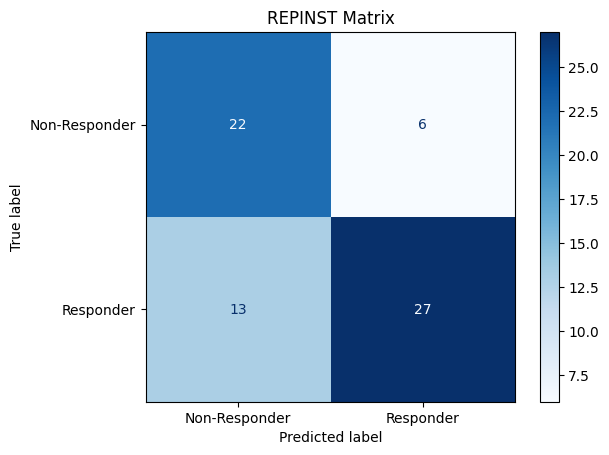

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = merged_df["Treatment Response"].map({"Responder": 1, "Non-Responder": 0})
y_pred = merged_df["REPINST_Predictions"].map({"Responder": 1, "Non-Responder": 0})

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Responder", "Responder"])
disp.plot(cmap='Blues')
plt.title("REPINST Matrix")
plt.show()


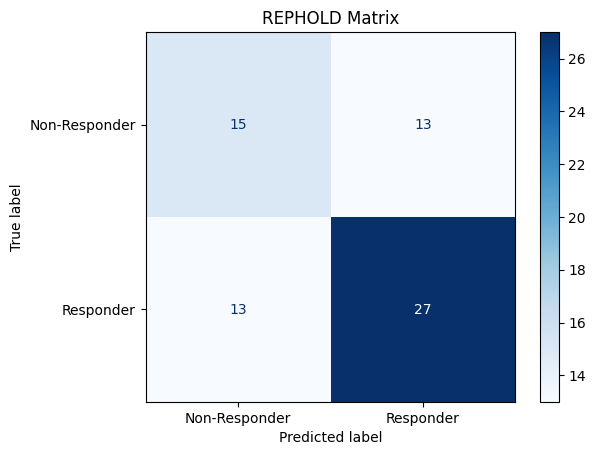

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = merged_df["Treatment Response"].map({"Responder": 1, "Non-Responder": 0})
y_pred = merged_df["REPHOLD_Predictions"].map({"Responder": 1, "Non-Responder": 0})

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Responder", "Responder"])
disp.plot(cmap='Blues')
plt.title("REPHOLD Matrix")
plt.show()
